## Подключение всех необходимых библиотек

In [1]:
import os
from functools import partial

import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from sklearn.model_selection import train_test_split
import tqdm
from torch import nn
from torch.functional import F
import torch.utils
import torch.utils.data
import torchaudio
import warnings

# Hyperparameters

In [6]:
SAMPLE_RATE = 22050
AUDIO_TIME_SECONDS = 4.6  # median of all recording durations

# Обработка аудио файлов и создание csv файла (датасета) с признаками

In [7]:
labeled_dataset = pd.read_csv("train_gt (1).csv")
header = "melspectrogram"

## 1. Заполнение csv файла данными

In [1]:
audio_length = round(AUDIO_TIME_SECONDS * SAMPLE_RATE)
for folder in ["train", "test"]:
    audios_cut = 0
    audios_padded = 0
    columns = (header if folder == "test" else header + " label").split()
    for filename in tqdm.tqdm(os.listdir(folder), desc=folder):
        feature_row_data = []
        songname = os.path.join(folder, filename)
        y, sr = librosa.load(songname, mono=True)
        y = librosa.resample(y, orig_sr=sr, target_sr=SAMPLE_RATE)
        if y / sr > AUDIO_TIME_SECONDS:
            if folder == "train":
                ... # TODO: split signal and pad last if isn't long enough
            else:
                ... # TODO: don't, either pad or cut.
        mel_df = pd.DataFrame(librosa.feature.melspectrogram(y=y))
        if folder == "train":
            mel_df["Label"] = bool(labeled_dataset[labeled_dataset["Filename"] == filename]["Label"].values[0])
        mel_df.to_csv(f"{folder}_data/{filename}_mel.csv") # TODO: if train, add a mark that signal is splitted
    print(f"saving {folder}...")        
    print(f"{folder}: {audios_cut=}, {audios_padded=}")

NameError: name 'AUDIO_TIME_SECONDS' is not defined

## Loading dataset and splitting into train/test

In [2]:
warnings.filterwarnings("ignore")
device = torch.device("mps")
X = []
y = []
for mel in tqdm.tqdm(os.listdir("train_data")):    
    df = pd.read_csv(os.path.join("train_data", mel))
    X.append(df.drop("Label", axis=1).values)
    y.append(df["Label"].values[0]) # "Label" is filled with True for compatibility, but we need only one value.
X = torch.tensor(X).unsqueeze(1)
y = torch.tensor(y).unsqueeze(1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

100%|██████████| 8803/8803 [00:39<00:00, 224.84it/s]


In [6]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, ind):
        return self.features[ind], self.labels[ind]

In [89]:
import torch.utils
import torch.utils.data


train_dataset = MyDataset(x_train, y_train)
test_dataset = MyDataset(x_test, y_test)
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

## Архитектура нашей нейронной сети

In [316]:
def find_conv2d_out_shape(hin,win,conv: nn.Conv2d,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation
    if not isinstance(padding, tuple):
        padding = (padding,padding)
    if not isinstance(stride, tuple):
        stride = (stride,stride)
    if not isinstance(dilation, tuple):
        dilation = (dilation,dilation)
    if not isinstance(kernel_size, tuple):
        kernel_size = (kernel_size,kernel_size)
    hout=np.floor((hin 
                   + 2*padding[0] 
                   - dilation[0] * (kernel_size[0]-1) - 1)
                   / stride[0] + 1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)


class MelConvNet(nn.Module):
    def __init__(self):
        super(MelConvNet, self).__init__()
        input_shape = (128, 200)
        conv1out = 3
        out_ch = 1
        pool1_kernel_size = 3
        
        self.conv1 = nn.Conv2d(1, conv1out, kernel_size=(12,12), stride=(1,1), padding=(0,0))
        width, height = find_conv2d_out_shape(input_shape[0], input_shape[1], self.conv1, pool=0)
        self.bc1 = nn.BatchNorm2d(width * height * conv1out)

        self.conv2 = nn.Conv2d(3, out_ch, (3,3), (1,1), (0,0))
        self.bc2 = nn.BatchNorm2d(width * height * out_ch)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))
        width, height = find_conv2d_out_shape(width, height, self.conv2, pool=2)
         
        # self.conv3 = nn.Conv2d(3, out_ch, (3,3), (1,1), (0,0))
        # # self.pool3 = nn.MaxPool2d(kernel_size=(2,2))
        # width, height = find_conv2d_out_shape(width, height, self.conv3, pool=0)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(width * height * out_ch, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
         
        x = self.conv1(x)
        x = self.bc1(x)

        x = self.conv2(x)
        x = self.bc2(x)
        x = self.pool2(x)
         
        # x = self.conv3(x)
        # x = self.pool3(x)
         
        x = self.flatten(x)
         
        x = self.fc1(x)
        x = self.sigmoid(x)
        
        return x

## и ее обучение

In [317]:
model = MelConvNet()
model.to(device)
total_epochs = 0

In [318]:
epochs = 1000
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr)
loss_fn = nn.BCELoss()
loaders = {"train": train_loader, "val": test_loader}
accuracy = {"train": [], "val": []}
val_progress = 0 # track accuracy improvement or degradation
VAL_DECREASE_BREAK = -3 # when decreased x times, model overfitted, stop training
model.train()
pbar = tqdm.tqdm(range(epochs))
for epoch in pbar:
    for key, loader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if key == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                loss = loss_fn(outp, y_batch)
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            total = y_batch.size(0)
            predicted = outp.data >= 0.5
            correct = (predicted == y_batch).sum().item()
            correct = sum(predicted == y_batch)
            all_ = len(outp)
            epoch_correct += correct.item()
            epoch_all += all_
        #scheduler.step()
        pbar.set_description(f"Loader: {key}. Accuracy: {epoch_correct/epoch_all:.2%}")
        accuracy[key].append(epoch_correct/epoch_all)
        if key == "val" and len(accuracy[key]) >= 2:
            if val_progress > 0:
                val_progress = 0
            if accuracy[key][-1] > accuracy[key][-2]:
                val_progress += 1
            else:
                val_progress -= 1
            if val_progress <= VAL_DECREASE_BREAK:
                print(f"OVERFITTED AT EPOCH {epoch}")
                break
    else: # if not broken with val decrease excision
        total_epochs += 1
        continue
    break
[plt.plot(accuracies, label=name) for name, accuracies in accuracy.items()]
plt.legend()

  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: running_mean should contain 3 elements not 66339

Conv2d
Conv2d
MaxPool2d
Flatten
Linear


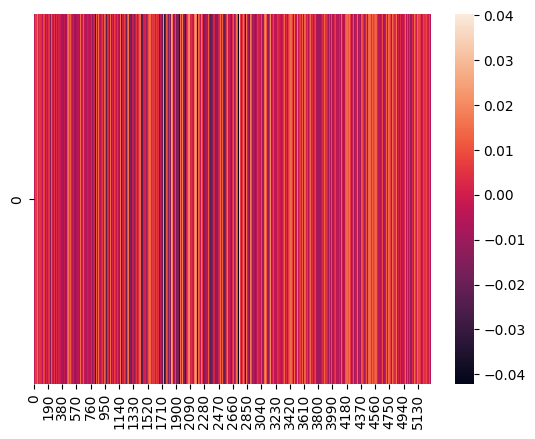

Sigmoid


In [ ]:
with torch.no_grad():
    for child in model.children():
        name = child._get_name()
        parameters = iter(child.parameters())
        print(name)
        if name == "Linear":
            seaborn.heatmap(next(parameters).cpu())
        plt.show()

# Submission

## Downloading dataset

In [ ]:
data_scoring = []
paths = []
for path in tqdm.tqdm(os.listdir("test_data")):   
    paths.append(path) 
    df = pd.read_csv(os.path.join("test_data", path))
    data_scoring.append(df.values)

  0%|          | 0/2870 [00:00<?, ?it/s]

100%|██████████| 2870/2870 [00:11<00:00, 250.17it/s]


## Submiting

In [ ]:
data_scoring = torch.tensor(data_scoring, dtype=torch.float32).to(device)
sample_submission = pd.read_csv("test (1).csv")
print("predicting..")
model.eval()
with torch.no_grad():
    results = model(data_scoring) >= 0.5

submission = pd.DataFrame({"Filename": paths, "Label": results.squeeze(1).to("cpu")})
submission = submission.sort_values(by="Filename")
sample_submission = sample_submission.sort_values(by="Filename")
sample_submission["Label"] = submission["Label"]
sample_submission = sample_submission.sort_index()
sample_submission.to_csv("submission.csv", index=False, header=False) 

predicting..


RuntimeError: Given groups=1, weight of size [3, 1, 12, 12], expected input[1, 2870, 128, 200] to have 1 channels, but got 2870 channels instead